In [58]:
# imports
import sympy as sm
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In order to recast the Huber loss as a valid likelihood function to be used in likelihood ratio tests, we need to derive the associated normalisation constant. We can achieve this using sympy, a symbolic computation package.

Using the same notation as in the PyTorchDIA paper, we can start by defining the class of distributions,

$f(x) = Q \times \frac{1}{\sigma} \times \exp({-\rho(x)})$.

$Q$ is the normalisation constant we're interested in deriving. In order to find $Q$, we need to integrate everything to its right over the entire range of $x$. Setting $Q$ equal to the reciprocal of the result of this integration will ensure that when $f(x)$ is integrated over the entire range of $x$ the result will always be $1$ i.e. $f(x)$ is now a valid probability distribution.

We'll start with the Gaussian case, where

$\rho(x) = \frac{1}{2}\frac{x^2}{\sigma^2}\;.$

N.B. Under the above definition for $f(x)$, we already have the $\sigma$ term that turns up in the usual derivation of the normalisation constant for a Gaussian, so integrating this expression should give us $\sqrt{2\pi}$. Let's use sympy to do this for us.

In [2]:
# first, test this out for the gaussian case
x, sigma = sm.symbols("x, sigma", real=True, positive=True)
rho = ((x / sigma) ** 2 )/ 2
loss = sm.exp(-rho) / sigma
norm = 2*sm.integrate(loss, (x, 0, sm.oo))
sm.simplify(norm)

sqrt(2)*sqrt(pi)

OK great, that seems to work! Now let's do the same for the Huber loss.

\begin{equation}
    \rho_{\text{Huber}, c}(x) =
    \begin{cases}
    \frac{1}{2}\frac{x^2}{\sigma^2}, & \text{for } |\frac{x}{\sigma}|\leq c \\
    c(|\frac{x}{\sigma}| - \frac{1}{2}c), & \text{for } |\frac{x}{\sigma}| > c \;.
    \end{cases}
    \label{eq:huber_loss}
\end{equation}

I don't expect the result will be quite as tidy as above!

In [4]:
# normalisation constant for Huber 'likelihood'
x, c, sigma = sm.symbols("x, c, sigma", real=True, positive=True)
rho = sm.Piecewise(
    ((x / sigma) ** 2 / 2, (x / sigma) <= c),
    (c * (sm.Abs(x / sigma) - c / 2), ((x / sigma) > c))
)
loss = sm.exp(-rho) / sigma
norm = 2 * sm.integrate(loss, (x, 0, sm.oo))
sm.simplify(norm)

sqrt(2)*sqrt(pi)*erf(sqrt(2)*c/2) + 2*exp(-c**2/2)/c

In [4]:
#const = (np.sqrt(2 * np.pi) * math.erf(c / np.sqrt(2))) + ((2 / c) * np.exp(-0.5 * c**2)) 

OK, on to the meat of this notebook. I'm not certain that it makes sense to compare a Huber likelihood against a Gaussian, even for instances in which there are no outlying data points. We can probe this question with a toy example; fitting a straight line to data with known Gaussian uncertainties.

It may be that the Huber likelihood (evaluated at the MLE) is strongly dependent on the tuning paramter, $c$. In the case where $c$ tends to infinity, we should expect the same value for the likelihood as for the Gaussian case. In this special case, not only are all residuals from the model treated as 'inliers', but note too that the normalisation constant we found above would also tend to $\sqrt{2\pi}$; the error function in the first term becomes unity and the latter term becomes neglibily small. However, for useful, smaller values of $c$ e.g. 1.345, in which 'outlying' residuals are treated linearly rather than quadratically, should we expect to get roughly the same values for the likelihoods? In other words, does the linear treatment of outliers balance with the change to the normalisation constant, which is itself dependent on $c$. I don't see how it could... but's let's verify this numerically.

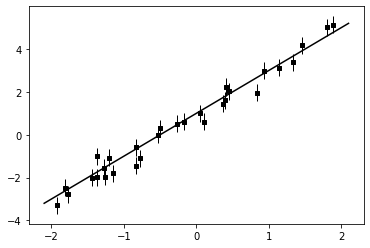

In [45]:
## Generate some mock data

# The linear model with slope 2 and intercept 1:
true_params = [2.0, 1.0]

# points drawn from true model
np.random.seed(42)
x = np.sort(np.random.uniform(-2, 2, 30))
yerr = 0.4 * np.ones_like(x)
y = true_params[0] * x + true_params[1] + yerr * np.random.randn(len(x))

# true line
x0 = np.linspace(-2.1, 2.1, 200)
y0 = np.dot(np.vander(x0, 2), true_params)

# plot
plt.errorbar(x, y, yerr=yerr, fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
plt.scatter(x, y, marker="s", s=22, c="k", zorder=1000)
plt.plot(x0, y0, c='k')

In [46]:
# analytic solution - MLE for a priori known Gaussian noise
def linear_regression(x, y, yerr):
    A = np.vander(x, 2)
    result = np.linalg.solve(np.dot(A.T, A / yerr[:, None]**2), np.dot(A.T, y / yerr**2))
    return result

res = linear_regression(x, y, yerr)
m, b = res

In [47]:
# optimise Huber loss

import torch
# initialise model parameters (y = m*x + b)
m_robust = torch.nn.Parameter(1e-3*torch.ones(1), requires_grad = True)
b_robust = torch.nn.Parameter(1e-3*torch.ones(1), requires_grad = True)
params_robust = list([m_robust, b_robust])

# negative log-likelihood for Huber likelihood (excluding the irrelevant normalisation constant)
def nll_Huber(model, data, yerr, c):
    
    # ln_sigma is same as above
    ln_sigma = torch.log(yerr).sum()

    # define inliers and outliers with a threshold, c
    resid = torch.abs((model - data)/yerr)
    cond1 = resid <= c
    cond2 = resid > c
    
    inliers = ((model - data)/yerr)[cond1]
    outliers = ((model - data)/yerr)[cond2]
    
    # Huber loss can be thought of as a hybrid of l2 and l1 loss
    # apply l2 (i.e. normal) loss to inliers, and l1 to outliers
    l2 = 0.5*torch.pow(inliers, 2).sum()
    l1 = (c * torch.abs(outliers) - (0.5 * c**2)).sum()
    
    nll = ln_sigma + l2 + l1
    
    return nll

# pass paramterers to optimizer
optimizer_robust = torch.optim.Adam(params_robust, lr = 0.01)

In [53]:
# tuning parameter, c
c = 1.345

xt, yt, yerrt = torch.from_numpy(x), torch.from_numpy(y), torch.from_numpy(yerr)

for epoch in range(2000): 

    model = m_robust*xt + b_robust
    
    # negative loglikelihood
    loss = nll_Huber(model, yt, yerrt, c)
    
    optimizer_robust.zero_grad() 
    loss.backward() 
    optimizer_robust.step()
    
    if np.mod(epoch, 100) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}  m={:03f}  b={:03f}'.format(
            epoch, loss.item(), m_robust.item(), b_robust.item())) 

0   : loss=-16.117150  m=2.061463  b=0.942204
100 : loss=-16.138877  m=2.075715  b=0.943876
200 : loss=-16.138879  m=2.075600  b=0.943839
300 : loss=-16.138879  m=2.075600  b=0.943839
400 : loss=-16.138879  m=2.075600  b=0.943839
500 : loss=-16.138879  m=2.075600  b=0.943839
600 : loss=-16.138879  m=2.075600  b=0.943839
700 : loss=-16.138879  m=2.075600  b=0.943839
800 : loss=-16.138879  m=2.075600  b=0.943839
900 : loss=-16.138879  m=2.075600  b=0.943839
1000: loss=-16.138879  m=2.075600  b=0.943839
1100: loss=-16.138879  m=2.075600  b=0.943839
1200: loss=-16.138879  m=2.075600  b=0.943839
1300: loss=-16.138879  m=2.075600  b=0.943839
1400: loss=-16.138879  m=2.075600  b=0.943839
1500: loss=-16.138879  m=2.075600  b=0.943839
1600: loss=-16.138879  m=2.075600  b=0.943839
1700: loss=-16.138879  m=2.075600  b=0.943839
1800: loss=-16.138879  m=2.075601  b=0.943839
1900: loss=-16.138879  m=2.075601  b=0.943839


In [54]:
m_r, b_r = m_robust.item(), b_robust.item()

In [55]:
def evaluate_gaussian_log_likelihood(data, model, var):
    print('\nGaussian log-likelihood')
    chi2 = 0.5 * ((data - model)**2 / var).sum()
    lnsigma = np.log(np.sqrt(var)).sum()
    norm_constant = len(data.flatten()) * 0.5 * np.log(2 * np.pi)
    print('chi2, lnsigma, norm_constant:', chi2, lnsigma, norm_constant)
    return -(chi2 + lnsigma + norm_constant)

def evaluate_huber_log_likelihood(data, model, var, c):
    print('\nHuber log-likelihood')
    
    ## PyTorchDIA - 'Huber' likelihood
    sigma = np.sqrt(var)
    ln_sigma = np.log(sigma).sum()

    # gaussian when (model - targ)/sigma <= c
    # absolute deviation when (model - targ)/sigma > c
    cond1 = np.abs((model - data)/sigma) <= c
    cond2 = np.abs((model - data)/sigma) > c
    inliers = ((model - data)/sigma)[cond1]
    outliers = ((model - data)/sigma)[cond2]

    l2 = 0.5*(np.power(inliers, 2)).sum()
    l1 = (c *(np.abs(outliers)) - (0.5 * c**2)).sum()

    constant = (np.sqrt(2 * np.pi) * math.erf(c / np.sqrt(2))) + ((2 / c) * np.exp(-0.5 * c**2)) 
    norm_constant = len(data.flatten()) * np.log(constant)
    ll = -(l2 + l1 + ln_sigma + norm_constant)
    print('l2, l1, ln_sigma, norm_constant:', l2, l1, ln_sigma, norm_constant)
    return ll

In [56]:
# MLE models
model = m*x + b # Gaussian
model_r = m_r*x + b_r # Huber

In [57]:
ll_gaussian = evaluate_gaussian_log_likelihood(x, model, yerr**2)
print(ll_gaussian)
ll_huber = evaluate_huber_log_likelihood(x, model_r, yerr**2, c=c)
print(ll_huber)


Gaussian log-likelihood
chi2, lnsigma, norm_constant: 173.83346014331022 -27.488721956224655 27.56815599614018
-173.91289418322575

Huber log-likelihood
l2, l1, ln_sigma, norm_constant: 4.538741913408627 81.53652455056039 -27.488721956224655 29.357945837155103
-87.94449034489946


Unless I've blundered, it seems like the Huber log-likelihood is always going to exceed the Gaussian due to how the numerics are treated. If this is indeed correct, then any comparison between the two would be meaningless.